# Demo for generating compact reconfigurable and rigid-deployable random kirigami patterns

In [190]:
import numpy as np
import matplotlib.pyplot as plt
from Structure import *
from Utils import *

## Basic setup

In [191]:
# the pattern size
width = 16
height = 16

# create a square kirigami structure
structure = MatrixStructure(num_linkage_rows=height, num_linkage_cols=width)
bound_linkage_inds = [structure.get_boundary_linkages(i) for i in range(4)]
bound_directions = np.array([[-1.0, 0.0], [0.0, -1.0], [1.0, 0.0], [0.0, 1.0]])
boundary_points = []
corners = []
for i, bound in enumerate(bound_linkage_inds):
    local_boundary_points = []
    for j, linkage_ind in enumerate(bound):
        p = structure.is_linkage_parallel_to_boundary(linkage_ind[0], linkage_ind[1], i)
        if j == 0:
            corner = np.array([linkage_ind[1], -linkage_ind[0]]) + bound_directions[i]
            if not p:
                corner += bound_directions[(i-1)%4]
            corners.append(corner)
        if not p:
            point = np.array([linkage_ind[1], -linkage_ind[0]]) + bound_directions[i]
            local_boundary_points.append(point)
    boundary_points.append(np.vstack(local_boundary_points))
corners = np.vstack(corners)
print("Corners:\n", corners)
# corners = np.array([
#     [-1.0,           0.0],           # top-left
#     [-1.0, -float(height)],          # bottom-left
#     [ float(width), -float(height)],  # bottom-right
#     [ float(width),  1.0],           # top-right
# ])
boundary_offsets = [[0.0]*height, [0.0]*width, [0.0]*height, [0.0]*width]


Corners:
 [[ -1.   0.]
 [  0. -16.]
 [ 16. -15.]
 [ 15.   1.]]


In [192]:
len(bound_linkage_inds[0])

16

## Generate random offsets and get the resulting kirigami pattern

In [193]:
# create random offsets within (-0.9, 9)
interior_offsets = np.power(10, np.random.rand(height,width) * 2 - 1) - 1
# clampt it
interior_offsets = np.clip(interior_offsets, -0.9, 1.0)
# create random offsets within (-0.9, 0.9)
# interior_offsets = np.random.rand(height, width) * 1.8 - 0.9

# get the resulting random kirigami pattern using the linear inverse design method
structure.linear_inverse_design(np.vstack(boundary_points), corners, interior_offsets, boundary_offsets)
structure.assign_node_layers()
structure.assign_quad_genders()
structure.make_hinge_contact_points()


## Plot the result

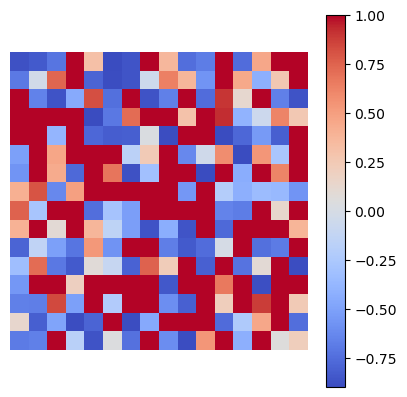

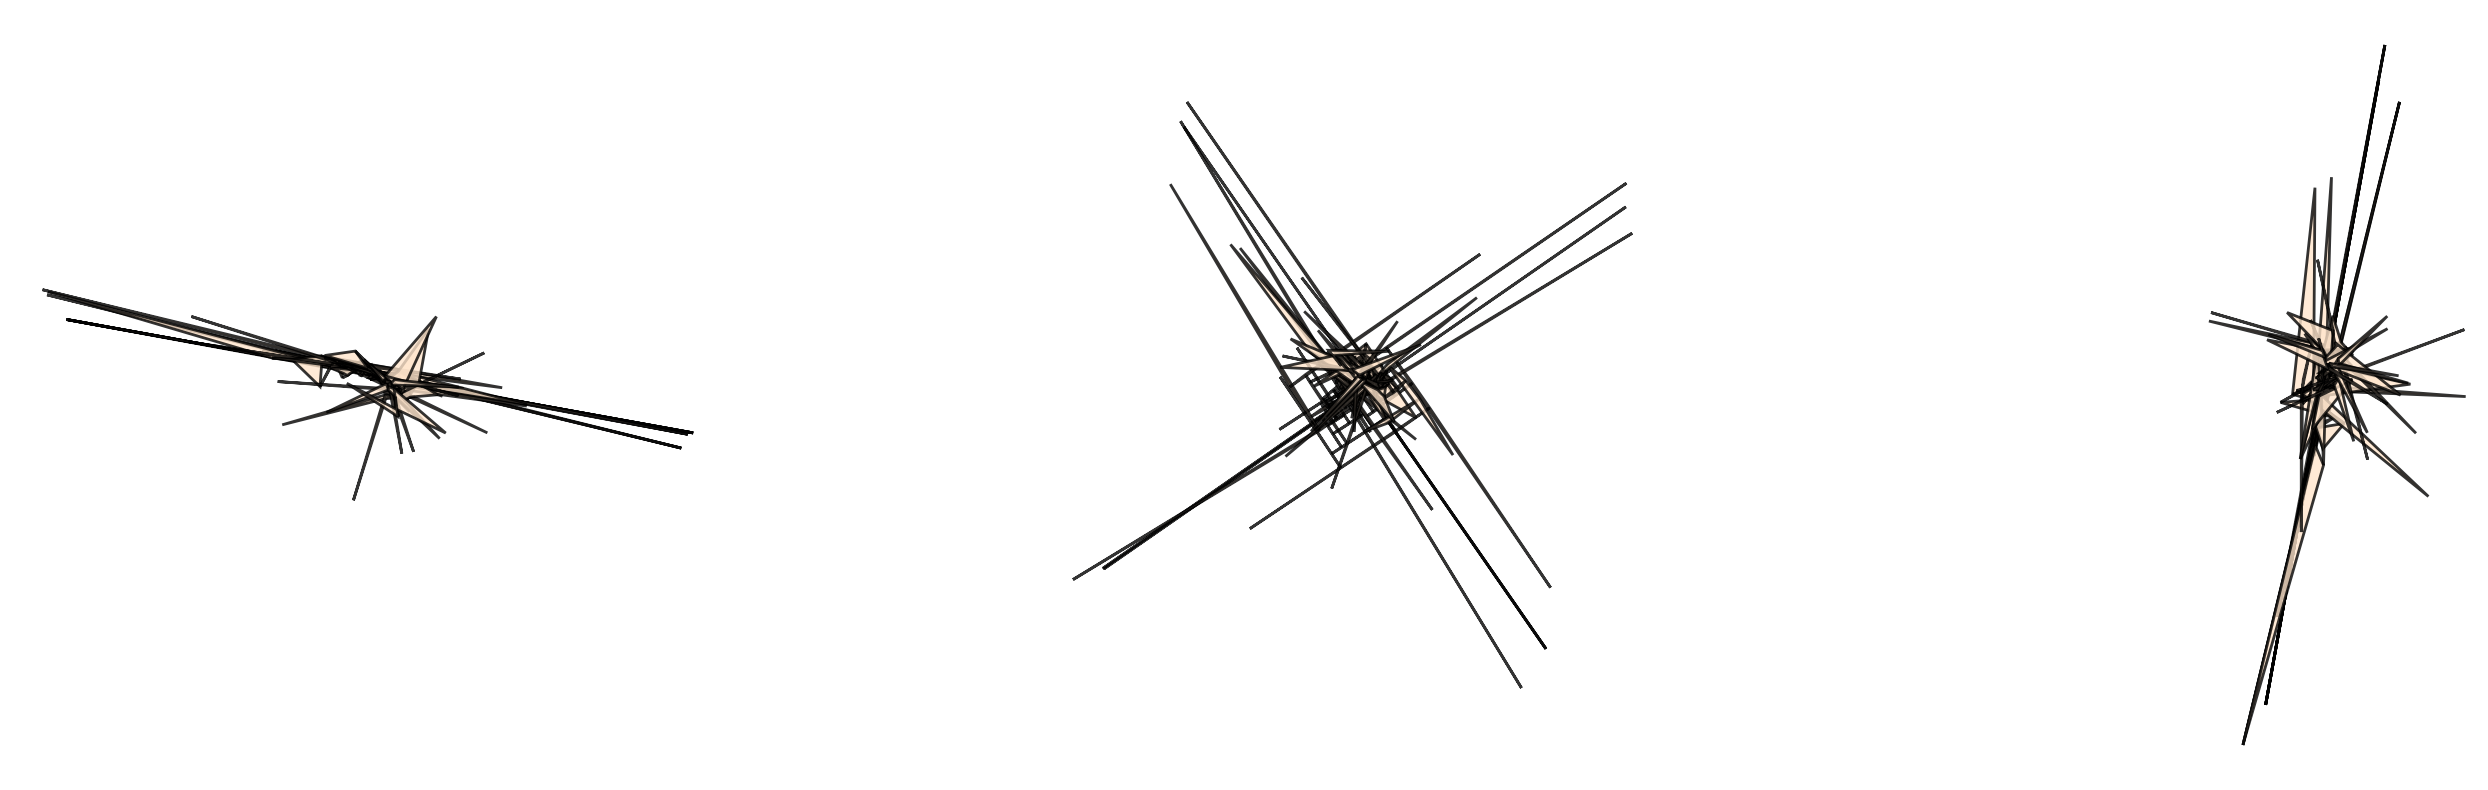

In [194]:
# plot the offset field
plt.matshow(interior_offsets, cmap='coolwarm')
plt.axis('off')
cbar = plt.colorbar()


# plot deployment snapshots of the structure created
num_frames = 3
phis = np.linspace(np.pi, 0, num_frames)
panel_size = 10
fig, axs = plt.subplots(1, num_frames, figsize=(1.2*panel_size*num_frames, panel_size), sharey=True)

for ax_ind, phi in enumerate(phis):
    
    deployed_points, deployed_hinge_contact_points = structure.layout(phi)
    deployed_points = rotate_points(deployed_points, np.array([0, 0]), -(np.pi - phi)/2.0)
    
    deployed_points[:,0] = deployed_points[:,0] - (np.max(deployed_points[:,0])+np.min(deployed_points[:,0]))/2
    deployed_points[:,1] = deployed_points[:,1] - (np.max(deployed_points[:,1])+np.min(deployed_points[:,1]))/2
    
    plot_structure(deployed_points, structure.quads, structure.linkages, axs[ax_ind])
    axs[ax_ind].set_aspect('equal')
    
#     write_obj('Example_random_' + str(ax_ind) +'.obj', deployed_points, structure.quads)

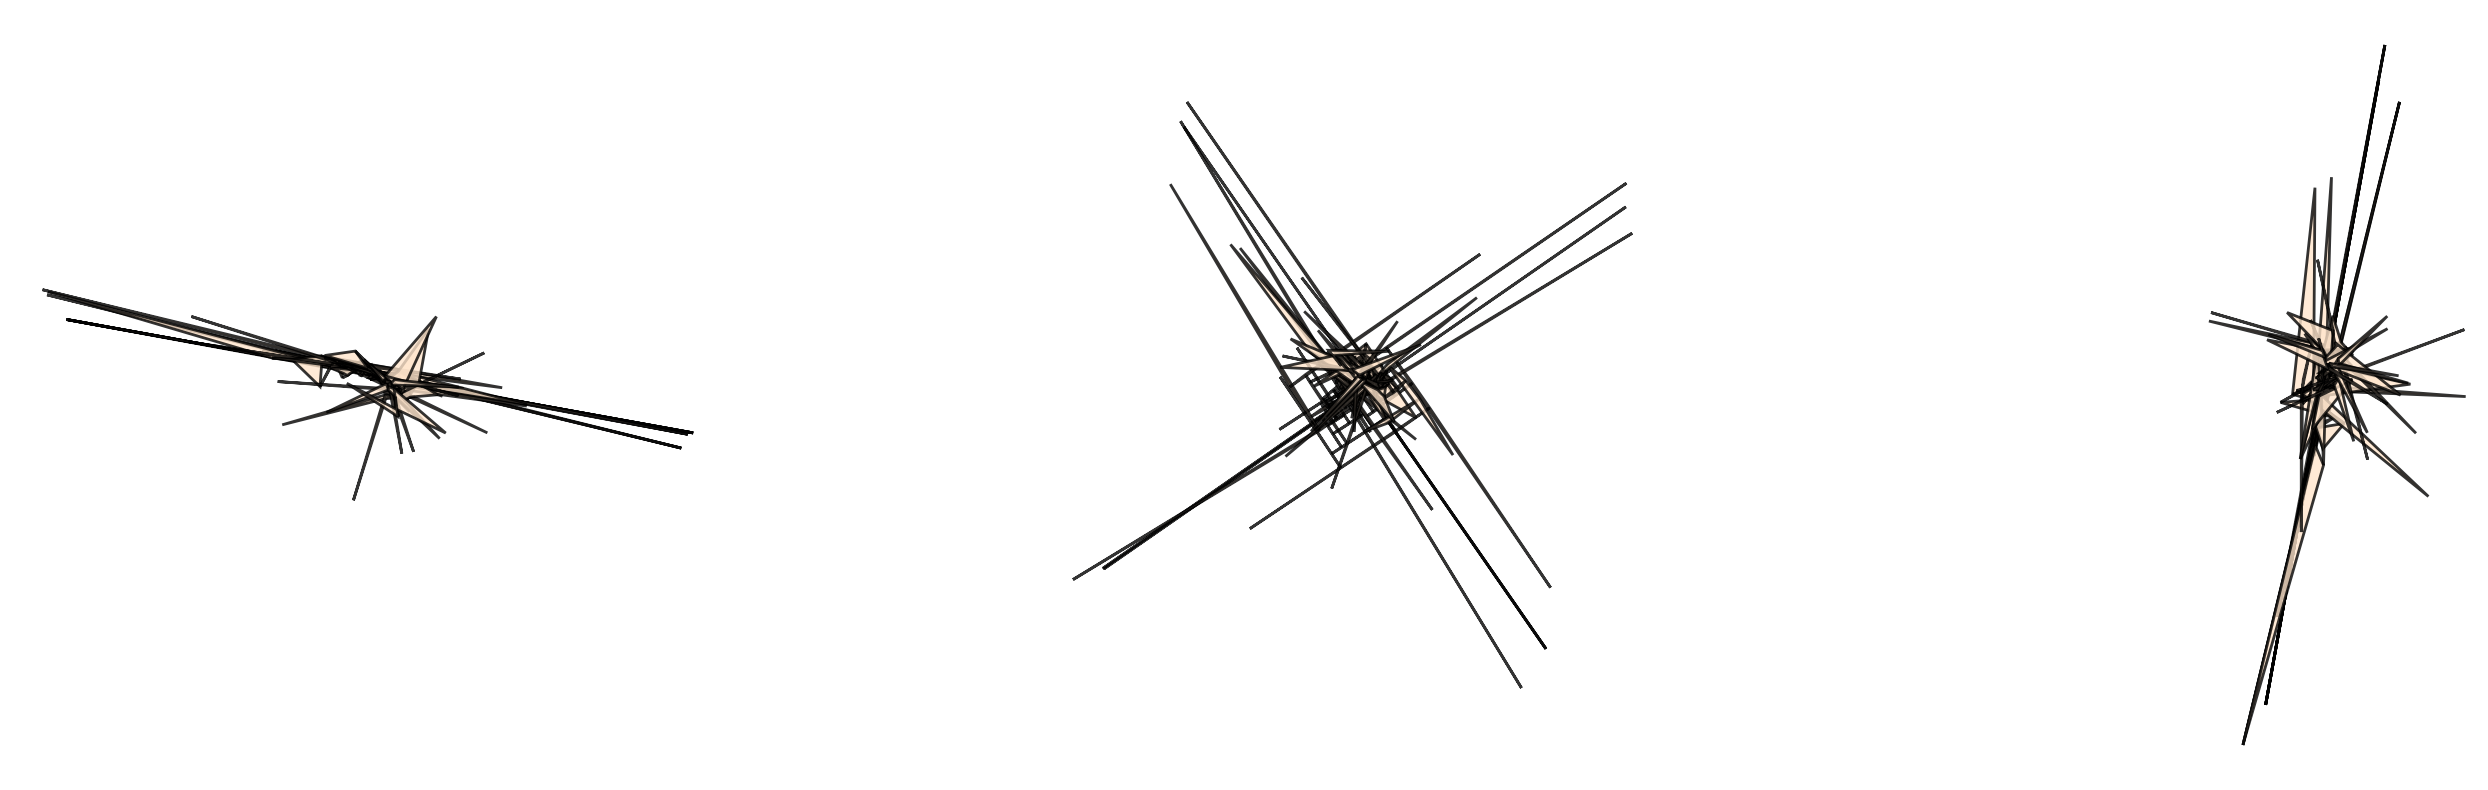

In [195]:
import numpy as np
from Structure import MatrixStructure

def make_phi0_structure(interior_offsets):
    """
    Build a compact-reconfigurable, rigid-deployable kirigami structure
    at phi = 0 from a given interior offset field.

    Parameters
    ----------
    interior_offsets : (H, W) ndarray
        The offset field ε_ij (one value per linkage). Values must be > -1
        (the demo typically uses ε in [-0.9, 9]).

    Returns
    -------
    structure : MatrixStructure
        The populated structure object (quads, linkages, etc.).
    points_phi0 : (N, 2) ndarray
        Node coordinates at phi = 0 (first contracted state).
    hinge_points_phi0 : (M, 2) ndarray
        Hinge contact points at phi = 0 (useful for visualization/fabrication).
    """
    # Infer array size
    height, width = interior_offsets.shape

    # Create the linkage array object
    structure = MatrixStructure(num_linkage_rows=height, num_linkage_cols=width)

    # --- Build boundary points and corners exactly like the demo ---
    bound_linkage_inds = [structure.get_boundary_linkages(i) for i in range(4)]
    bound_directions = np.array([[-1.0, 0.0], [0.0, -1.0], [1.0, 0.0], [0.0, 1.0]])
    boundary_points = []
    corners = []

    for i, bound in enumerate(bound_linkage_inds):
        local_boundary_points = []
        for j, linkage_ind in enumerate(bound):
            # linkage_ind = (row_index, col_index)
            p = structure.is_linkage_parallel_to_boundary(linkage_ind[0], linkage_ind[1], i)

            # Corner of this side (first linkage on the side)
            if j == 0:
                corner = np.array([linkage_ind[1], -linkage_ind[0]]) + bound_directions[i]
                if not p:
                    corner += bound_directions[(i - 1) % 4]
                corners.append(corner)

            # Non-parallel boundary nodes
            if not p:
                point = np.array([linkage_ind[1], -linkage_ind[0]]) + bound_directions[i]
                local_boundary_points.append(point)

        boundary_points.append(np.vstack(local_boundary_points))

    corners = np.vstack(corners)

    # Boundary offsets are zero (same as the demo)
    boundary_offsets = [[0.0] * height, [0.0] * width, [0.0] * height, [0.0] * width]

    # --- Linear inverse design (solves for seeds, then builds the full array) ---
    # This uses the compact-reconfigurable angle field internally; ϕ is supplied
    # later via structure.layout(...). Evaluating at ϕ=0 gives the first contracted state.
    structure.linear_inverse_design(np.vstack(boundary_points),
                                    corners,
                                    interior_offsets,
                                    boundary_offsets)

    # Optional helpers used in the demo (layering/genders/hinges metadata)
    structure.assign_node_layers()
    structure.assign_quad_genders()
    structure.make_hinge_contact_points()

    # Evaluate geometry at phi = 0 (first contracted state)
    points_phi0, hinge_points_phi0 = structure.layout(0.0)

    return structure, points_phi0, hinge_points_phi0


# -------------------------
# Example usage:
# eps = your (H, W) ndarray of offsets
structure, pts0, hinge_pts0 = make_phi0_structure(interior_offsets)

# plot the structure
num_frames = 3
phis = np.linspace(np.pi, 0, num_frames)
panel_size = 10
fig, axs = plt.subplots(1, num_frames, figsize=(1.2*panel_size*num_frames, panel_size), sharey=True)

for ax_ind, phi in enumerate(phis):
    
    deployed_points, deployed_hinge_contact_points = structure.layout(phi)
    deployed_points = rotate_points(deployed_points, np.array([0, 0]), -(np.pi - phi)/2.0)
    
    deployed_points[:,0] = deployed_points[:,0] - (np.max(deployed_points[:,0])+np.min(deployed_points[:,0]))/2
    deployed_points[:,1] = deployed_points[:,1] - (np.max(deployed_points[:,1])+np.min(deployed_points[:,1]))/2
    
    plot_structure(deployed_points, structure.quads, structure.linkages, axs[ax_ind])
    axs[ax_ind].set_aspect('equal')


calculate_design_matrix:
    phis is float, building deployment arrays using that
calculate_design_matrix:
    phis is float, building deployment arrays using that


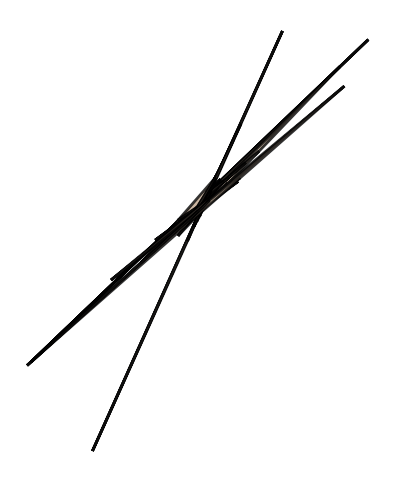

In [196]:
import numpy as np
import matplotlib.pyplot as plt
from Structure import *
from Utils import *

# Minimal-Change "random shape" generator with guaranteed rigid deployability
np.random.seed(1)

width, height = 12, 12
structure = DeployedMatrixStructure(num_linkage_rows=height, num_linkage_cols=width)

# boundary & corners built as above (SAME code)
boundary_points_blocks = []
for bound_ind in range(4):
    pts = []
    for (i, j) in structure.get_outer_boundary_linkages(bound_ind):
        if structure.is_linkage_parallel_to_boundary(i, j, bound_ind):
            pts.append([float(j), -float(i)])
    boundary_points_blocks.append(np.array(pts, dtype=float))
boundary_points = np.vstack(boundary_points_blocks)

corners = np.array([
    [-1.0,            0.0],
    [-1.0, -float(height)],
    [ float(width), -float(height)],
    [ float(width),   1.0],
], dtype=float)

# Random offsets in the safe range (paper’s choice: [-0.9, 9])
r = np.random.uniform(-1.0, 1.0, size=(height, width))
interior_offsets = np.power(10.0, r) - 1.0

boundary_offsets = [[0.0]*height, [0.0]*width, [0.0]*height, [0.0]*width]

# Enforce compact-reconfigurable angle field by passing a single phi
phi = 0.0   # try 0.0, np.pi, np.pi/2, etc.
structure.linear_inverse_design(
    boundary_points, corners,
    interior_offsets, boundary_offsets,
    phis=phi
)

structure.assign_node_layers()
structure.assign_quad_genders()
structure.make_hinge_contact_points()


# Optional: visualize tiles at this state (no marching/layout call needed)
fig, ax = plt.subplots(figsize=(6,6))
plot_structure(structure.points, structure.quads, structure.linkages, ax)
plt.show()
